## Performance Optimizations

### Parallelization

카메라에서 나오는 빛은 독립적이고, scene 은 읽는 작업만 하기 때문에 패널티나 동기화 복잡성 없이 하나의 CPU 코어당 하나의 ray를 추적할 수 있다.    

사실 raytracer 는 `embrassingly parallelizable` 이라는 알고리즘에 속해있다.    

`embrassingly parallelizable` : 병렬 컴퓨팅 연산의 알고리즘 중 하나이다. 병렬 임무 사이의 의존성이 거의 존재하지 않거나 없는 경우에 발생한다.     
`thread` : 프로세스 내에서 실행되는 흐름의 단위   

하지만 각 ray 당 하나의 `thread` 를 생성하는 것은 좋은 생각이 아니다. 수백만개의 스레드를 관리하는데 드는 오버헤드는 속도 향상을 무효화시킬것이다. 보다 합리적인 아이디어는 `task` 라 불리는 세트를 만드는것이다. 각각의 세트는 캔버스의 한 부분(사각형 영역, 단일 픽셀)을 추적하고, `thread`로 보낸다. 

### Caching Immutable Values

`Caching` 이란 같은 연산이 반복되는 것을 피하기 위한 한 방법이다.     
값이 변경되지 않는 경우에는, 연산한 값을 저장(캐시)한 후 다음번에 재사용하는것이 좋다.     


``` python
    def intersect_ray_sphere(self, origin, direction, sphere):
        origin = origin
        
        oc = np.subtract(origin, sphere.center)

        k1 = np.dot(direction, direction)
        k2 = 2*np.dot(oc, direction)
        k3 = np.dot(oc, oc) - sphere.radius*sphere.radius

        discriminant = k2*k2 - 4*k1*k3
        if (discriminant < 0):
            return [math.inf, math.inf]

        t1 = (-k2 + math.sqrt(discriminant)) / (2*k1)
        t2 = (-k2 - math.sqrt(discriminant)) / (2*k1)
        return [t1, t2] 
```
 
 
위의 `intersect_ray_sphere` 에서 `np.dot(direction, direction)` 의 경우 모든 ray들이 같은 값을 가지기 때문에 매 함수마다 계산하는 것이 아닌 계산된 값을 받아 사용할 수 있다. `spehre.radius * sphere.radius` 의 경우도 바뀌지 않는 값이기 때문에 미리 저장해놓고 사용할 수 있다. 

그러나 때때로 `bookkeeping overhead` 가 절약된 시간보다 클 수 있기 때문에 캐시된 모든 값들이 전반적으로 더 빠른 것은 아니다.  
따라서 항상 기준을 잡아 최적화가 실제로 도움이 되는지 여부를 판단해야한다. 

`bookkeeping` : 계산된 값을 저장하는 것. 

### Shadow Optimizations

표면의 한 지점이 그림자에 있는 경우, 표면의 바로 옆에 있는 점 역시 동일한 물체의 그림자에 있을 가능성이 높다. 이를 그림자 일관성(shadow coherence)이라고 한다.   

![이미지](https://gabrielgambetta.com/computer-graphics-from-scratch/images/09-shadow-coherence.png) 

기존에는 모든 물체와의 교차점을 확인해야 했지만, 해당 점 옆에 특정 물체의 그림자가 있으면 먼저 물체와의 교차점을 확인할 수 있다. 따라서 모든 물체를 확인할 필요가 없게 된다. 만약 물체와의 교차점을 찾지 못한다면, 모든 물체를 확인한다.    

또한 빛과 물체의 교차점을 찾는 과정에서 가장 가까운 교차점을 찾을 필요가 없다. 최소한 하나의 교차점으로 충분하기 때문에 만약 교차점을 찾았다면 반복문을 끝내도 된다. 가장 가까운 원을 리턴하는 것이 아닌, 교차되는 구가 있는지를 Boolean 형식으로 내보내도 된다.   

In [2]:
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt

In [23]:
class World:
    def __init__(self,
                lights,
                spheres,
                cameras):
        self.lights = lights
        self.spheres = spheres
        self.cameras = cameras
        
        
class Light:
    def __init__(self, ltype, intensity, position=None, direction=None):
        self.ltype = ltype
        self.intensity = intensity
        self.position = np.array(position)
        self.direction = np.array(direction)
        
        
class Sphere:
    def __init__(self, center, radius, color, specular, reflective):
        self.center = np.array(center)
        self.radius = radius
        self.color = np.array(color)
        self.specular = specular
        self.reflective = reflective
        self.squared_radius = None
        
    def square_radius(self):
        if self.squared_radius == None:
            self.squared_radius = self.radius * self.radius
            
        return self.squared_radius
        
class Camera:
    def __init__(self,
                 camera_position = [0, 0, 0],
                 camera_rotation = [0, 0, 0],
                 viewport_size=1,
                 projection_plane_z=1,
                 recursion_depth=3,
                 background_color=np.array([0,0,0])):
        
        x_rotate = np.array([[1, 0, 0],
                   [0, math.cos(math.pi * camera_rotation[0] / 180), -(math.sin(math.pi * camera_rotation[0] / 180))],
                   [0, math.sin(math.pi * camera_rotation[0] / 180), math.cos(math.pi * camera_rotation[0] / 180)]])
        y_rotate = np.array([[math.cos(math.pi * camera_rotation[1] / 180),0,math.sin(math.pi * camera_rotation[1] / 180)],
                   [0, 1, 0],
                   [-(math.sin(math.pi * camera_rotation[1] / 180)), 0, math.cos(math.pi * camera_rotation[1] / 180)]])
        z_rotate = np.array([[math.cos(math.pi * camera_rotation[2] / 180), -(math.sin(math.pi * camera_rotation[2] / 180)), 0],
                   [math.sin(math.pi * camera_rotation[2] / 180), math.cos(math.pi * camera_rotation[2] / 180), 0],
                   [0, 0, 1]])
        
        self.position = np.array(camera_position)
        self.rotation = np.dot(np.dot(x_rotate, y_rotate), z_rotate)
        self.viewport_size = viewport_size # view port size in world unit
        self.projection_plane_z = projection_plane_z # view port's distance from camera in world unit
        
        self.t_min = 1
        self.t_max = math.inf
        
        self.background_color = background_color
        
        self.recursion_depth = recursion_depth

    
    def traceray(self,
                 origin, 
                 direction,
                 spheres = None, 
                 lights = None,
                 recursion_depth=3):
        origin = origin
        t_min = self.t_min
        t_max = self.t_max
        spheres = spheres
        closest_sphere, closest_t = self.intersect_closest_point(origin,
                                                        direction,
                                                        t_min,
                                                        t_max,
                                                        spheres)

        if closest_sphere == None:
            return self.background_color

        point = np.add(origin, np.multiply(closest_t, direction))
        normal = np.subtract(point, closest_sphere.center)
        normal = np.multiply(1.0 / np.linalg.norm(normal), normal)
        view = np.multiply(-1, direction)
        
        local_color = self.compute_light(point, normal, view, closest_sphere.specular, lights, spheres) * closest_sphere.color
        
        # if recurrsion limit  or object is not reflective, end
        r = closest_sphere.reflective
        if recursion_depth <= 0 or r <= 0:
            return local_color
        
        
        # Compute reflected color
        R = self.reflect_ray(view, normal)
        
        reflected_color = self.traceray(point, R, spheres, lights, recursion_depth - 1)
        
        return local_color*(1-r) + reflected_color*r
    
    def intersect_closest_point(self, origin, direction, t_min, t_max, spheres):
        closet_t = math.inf
        closet_sphere = None
        k1 = np.dot(direction,direction)
        
        for sphere in spheres:
            
            t = self.intersect_ray_sphere(origin, direction, sphere, k1)
            
            if (t_min < t[0] < t_max) & (t[0] < closet_t):
                closet_t = t[0]
                closet_sphere = sphere
                
            if (t_min < t[1] < t_max) & (t[1] < closet_t):
                closet_t = t[1]
                closet_sphere = sphere
                
        return closet_sphere, closet_t
    
    def intersect_point(self, origin, direction, t_min, t_max, spheres):
        closet_t = math.inf
        closet_sphere = None
        k1 = np.dot(direction,direction)
        
        for sphere in spheres:
            
            t = self.intersect_ray_sphere(origin, direction, sphere, k1)
            
            if (t_min < t[0] < t_max) & (t[0] < closet_t):
                closet_t = t[0]
                closet_sphere = sphere
                return True
                
            if (t_min < t[1] < t_max) & (t[1] < closet_t):
                closet_t = t[1]
                closet_sphere = sphere
                return True
                
        return False
    
    def intersect_ray_sphere(self, origin, direction, sphere, in_k1):
        origin = origin
        
        oc = np.subtract(origin, sphere.center)

        k1 = in_k1
        k2 = 2*np.dot(oc, direction)
        k3 = np.dot(oc,oc) - sphere.square_radius()
        # k3 = np.dot(oc, oc) - sphere.radius*sphere.radius

        discriminant = k2*k2 - 4*k1*k3
        if (discriminant < 0):
            return [math.inf, math.inf]

        t1 = (-k2 + math.sqrt(discriminant)) / (2*k1)
        t2 = (-k2 - math.sqrt(discriminant)) / (2*k1)
        return [t1, t2]
    
    def compute_light(self, point, normal, view, specular, lights, spheres):
        intensity = 0
        length_n = np.linalg.norm(normal)
        length_v = np.linalg.norm(view)
        for i, light in enumerate(lights):
            if light.ltype == 0:
                intensity += light.intensity
            else :
                vec_l = []
                if light.ltype == 1:
                    vec_l = np.subtract(light.position, point)
                    t_max = 1
                else :  #DIRECTIONAL
                    vec_l = light.direction
                    t_max = math.inf
        
            #Shadow check
                is_intersected = self.intersect_point(point, vec_l, 0.001, t_max, spheres)
                if is_intersected:
                    continue
                
          # Diffuse reflection.
                n_dot_l = np.dot(normal, vec_l)
                if( n_dot_l > 0) :
                    intensity += light.intensity * n_dot_l / (length_n * np.linalg.norm(vec_l))


          # Specular reflection.
                if (specular != -1 ):
                    vec_r = 2 * normal * np.dot(normal, vec_l) - vec_l
                    # vec_r = np.subtract(np.multiply(2.0*np.dot(normal, vec_l), normal), vec_l)
                    r_dot_v = np.dot(vec_r, view)
                    if (r_dot_v > 0):
                        intensity += light.intensity * math.pow(r_dot_v / (np.linalg.norm(vec_r) * length_v), specular)
        return np.array(intensity)
    
    def reflect_ray(self,R,N):
        return 2 * N * np.dot(N, R) - R

In [24]:
class Canvas:
    def __init__(self,
                 width=600, 
                 height=600):
        self.width = width
        self.height = height
        
        self.img = np.zeros((width,height,3), dtype = np.uint8)
        
    def putpixel(self, x, y, color):
        x = self.width/2 + x
        y = self.height/2 - y -1
        if (x< 0 or x >= self.width or y < 0 or y >= self.height):
            return 
        R = int(color[0])
        G = int(color[1])
        B = int(color[2])
        cv2.line(self.img, (int(x), int(y)), (int(x), int(y)), (R,G,B))
        
        
class Renderer:
    '''
    Canvas
    World
    '''
    def __init__(self,
                canvas,
                world):
        self.canvas = canvas 
        self.world = world
    
    def render(self, camera_idx=0):
        canvas_width = self.canvas.width
        canvas_height = self.canvas.height
        
        
        
        x_s = -canvas_width/2
        y_s = -canvas_height/2
        
        for i in range(canvas_width):
            for j in range(canvas_height):
                curr_x = x_s + i
                curr_y = y_s + j
                direction = self.canvas2viewport([curr_x, curr_y], camera_idx)
                direction = np.dot(self.world.cameras[camera_idx].rotation, direction)
                color = self.traceray(camera_idx, direction)
                #color = traceray(camera_position, direction, 1, math.inf)
                self.canvas.putpixel(curr_x, curr_y,color)
        
        plt.imshow(self.canvas.img)
        return 
    
    def canvas2viewport(self, point2d, camera_idx):
        camera = self.world.cameras[camera_idx]
        
        viewport_size = camera.viewport_size
        canvas_width = self.canvas.width
        canvas_height = self.canvas.height
        projection_plane_z = camera.projection_plane_z
        
        return [point2d[0] * viewport_size / canvas_width, point2d[1] * viewport_size / canvas_height, projection_plane_z]
    
    def traceray(self, camera_idx, direction):
        camera = self.world.cameras[camera_idx]
        
        color = camera.traceray(camera.position,
                                direction,  
                                spheres=self.world.spheres, 
                                lights = self.world.lights,
                                recursion_depth=camera.recursion_depth)
        
        # color = traceray(camera_position, direction, 1, math.inf)
        return color

In [25]:
AMBIENT = 0
POINT = 1
DIRECTIONAL = 2

light1 = Light(AMBIENT, 0.2, None)
light2 = Light(POINT, 0.6, position=[2,1,0])
light3 = Light(DIRECTIONAL, 0.2, direction=[1,4,4])
lights = [light1, light2, light3]


sphere1 = Sphere([0, -1, 3], 1, [255, 0, 0], 500, 0.2)
sphere2 = Sphere([2, 0, 4], 1, [0, 255, 0], 500, 0.3)
sphere3 = Sphere([-2, 0, 4], 1, [0, 0, 255], 10, 0.4)
sphere4 = Sphere([0, -5001, 0], 5000, [255, 255, 0], 1000, 0.5)
spheres = [sphere1, sphere2, sphere3, sphere4]

camera1 = Camera(camera_position=[3,0,1], camera_rotation=[0,-45,0], recursion_depth=0) # no reflection
camera2 = Camera(camera_position=[0,3,0], camera_rotation=[45,0,0], recursion_depth=3)# reflection
camera3 = Camera(camera_position=[0,10,3], camera_rotation=[90,0,0], recursion_depth=0, background_color=[255,255,255])
cameras = [camera1, camera2, camera3]

world = World(lights=lights,
             spheres=spheres,
             cameras=cameras)

canvas = Canvas()

renderer = Renderer(canvas, world)

Wall time: 27.3 s


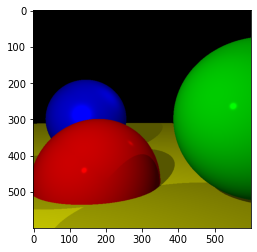

In [5]:
# 최적화 과정을 진행하지 않았을 때
%%time
renderer.render()

Wall time: 23 s


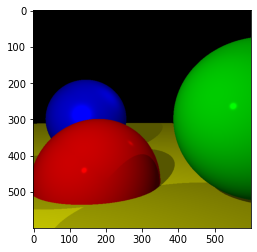

In [27]:
%%time
renderer.render()